# All imports #

In [1]:
from __future__ import print_function

import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import tensorflow.keras
import pandas as pd
import numpy as np
import sklearn
import keras
import csv

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input

from keras_uncertainty.models import MCDropoutClassifier, MCDropoutRegressor
from keras_uncertainty.utils import numpy_regression_nll
from keras_uncertainty.models import DeepEnsembleRegressor, deep_ensemble_regression_nll_loss



/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/d

In [2]:
def load_joint_space_csv_chunks(file_path):
    data_frame = pd.read_csv(file_path, skiprows=1, header=None)
    del data_frame[18]
    return data_frame

def load_task_space_csv_chunks(file_path):
    return pd.read_csv(file_path, skiprows=1, header=None)


In [3]:
##please select the appropriate folder, willl use os.path.join() for completed script
TRAIN_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/'
TEST_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/test_4steps'

X_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_sysstate_q.csv')
x_train = load_task_space_csv_chunks(X_TRAIN_FILE)
q_train = load_joint_space_csv_chunks(Q_TRAIN_FILE)

X_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_sysstate_q.csv')
x_test = load_task_space_csv_chunks(X_TEST_FILE)
q_test = load_joint_space_csv_chunks(Q_TEST_FILE)

# Splitting the dataset with SD #

In [4]:
"""
+/- based data splitting
We consider the Q features and use the feature with the highest SD for dividing the dataset. 
We consider all the positive values as IOD and all the negative values as OOD
"""

stats_x_train = pd.DataFrame()
stats_x_train["Mean"] = x_train.mean()
stats_x_train["Var"] = x_train.var()
stats_x_train["STD"] = x_train.std()
stats_x_train["OneSigmaMax"] = stats_x_train["Mean"] + stats_x_train["STD"]
stats_x_train["OneSigmaMin"] = stats_x_train["Mean"] - stats_x_train["STD"]
stats_x_train.T

max_std = stats_x_train["STD"].max()
colomn_max_std = stats_x_train["STD"].idxmax()

value = 0

InDistribution_Q_Train =  q_train[x_train[0] > value]
OutDistribution_Q_Train = q_train[x_train[0] < value]
InDistribution_X_Train =  x_train[x_train[0] > value]
OutDistribution_X_Train = x_train[x_train[0] < value]

InDistribution_Q_Test =  q_test[x_test[0] > value]
OutDistribution_Q_Test = q_test[x_test[0] < value]
InDistribution_X_Test =  x_test[x_test[0] > value]
OutDistribution_X_Test = x_test[x_test[0] < value]

x_train_1 = InDistribution_X_Train
q_train_1 = InDistribution_Q_Train
x_test_1 = InDistribution_X_Test
q_test_1 = InDistribution_Q_Test

OOD_x_train = OutDistribution_X_Train
OOD_q_train = OutDistribution_Q_Train
OOD_x_test = OutDistribution_X_Test
OOD_q_test = OutDistribution_Q_Test

In [5]:
print(x_train_1.shape, x_test_1.shape, x_train.shape, x_test.shape)

(5226, 9) (1485, 9) (15625, 9) (4096, 9)


In [6]:

x_scaler = MinMaxScaler()
q_scaler = MinMaxScaler()

#In order training set
x_train_1 = x_scaler.fit_transform(x_train_1)
q_train_1 = q_scaler.fit_transform(q_train_1)

#complete test set
x_test = x_scaler.transform(x_test)
q_test = q_scaler.transform(q_test)

#split testing data
IOD_x_test = x_scaler.transform(x_test_1)
IOD_q_test = q_scaler.transform(q_test_1)

OOD_x_test = x_scaler.transform(OOD_x_test)
OOD_q_test = q_scaler.transform(OOD_q_test)

In [7]:

def model_builder():
    input_shape = 9
    output_shape = 18
    depth = 6
    width = 64
    reduction_factor = 0.9
    for i in range(depth):
        num_neurons = max(int(width * (reduction_factor ** i)), 4)
        if i == 0:
            inp = Input(shape=(input_shape,))
            x = Dense(num_neurons, activation='relu')(inp)
        else:
            x = Dense(num_neurons, activation='relu')(x)
            
    mean = Dense(output_shape, activation="sigmoid")(x)
    var = Dense(output_shape, activation="softplus")(x)
    
    train_model = Model(inp, mean)
    pred_model = Model(inp, [mean, var])

    train_model.compile(loss=deep_ensemble_regression_nll_loss(var), optimizer="adam", metrics=["mae"])
    return train_model, pred_model

In [8]:


model = model_builder

print(type(model))

<class 'function'>


In [15]:


with tf.device('/cpu:0'):
    ensemble_model = DeepEnsembleRegressor(model_builder, 3)
    ensemble_model.fit(x_train_1, q_train_1, epochs = 100, batch_size = 128, verbose = 1, validation_data=(IOD_x_test, IOD_q_test))

Train on 5226 samples, validate on 1485 samples
Epoch 1/100
5226/5226 [==============================] - 0s 89us/sample - loss: -0.2164 - mean_absolute_error: 0.2981 - val_loss: -0.4019 - val_mean_absolute_error: 0.3001
Epoch 2/100
5226/5226 [==============================] - 0s 22us/sample - loss: -0.4921 - mean_absolute_error: 0.2853 - val_loss: -0.5637 - val_mean_absolute_error: 0.2650
Epoch 3/100
5226/5226 [==============================] - 0s 20us/sample - loss: -0.6068 - mean_absolute_error: 0.2561 - val_loss: -0.6428 - val_mean_absolute_error: 0.2485
Epoch 4/100
5226/5226 [==============================] - 0s 20us/sample - loss: -0.7121 - mean_absolute_error: 0.2350 - val_loss: -0.7736 - val_mean_absolute_error: 0.2244
Epoch 5/100
5226/5226 [==============================] - 0s 21us/sample - loss: -0.8060 - mean_absolute_error: 0.2204 - val_loss: -0.8322 - val_mean_absolute_error: 0.2157
Epoch 6/100
5226/5226 [==============================] - 0s 21us/sample - loss: -0.8544 - me

5226/5226 [==============================] - 0s 25us/sample - loss: -1.9789 - mean_absolute_error: 0.0802 - val_loss: -1.9157 - val_mean_absolute_error: 0.0804
Epoch 96/100
5226/5226 [==============================] - 0s 21us/sample - loss: -1.9715 - mean_absolute_error: 0.0794 - val_loss: -1.9604 - val_mean_absolute_error: 0.0787
Epoch 97/100
5226/5226 [==============================] - 0s 26us/sample - loss: -1.9872 - mean_absolute_error: 0.0791 - val_loss: -1.9615 - val_mean_absolute_error: 0.0775
Epoch 98/100
5226/5226 [==============================] - 0s 23us/sample - loss: -1.9990 - mean_absolute_error: 0.0781 - val_loss: -1.9517 - val_mean_absolute_error: 0.0768
Epoch 99/100
5226/5226 [==============================] - 0s 21us/sample - loss: -2.0081 - mean_absolute_error: 0.0773 - val_loss: -1.8952 - val_mean_absolute_error: 0.0759
Epoch 100/100
5226/5226 [==============================] - 0s 23us/sample - loss: -1.9853 - mean_absolute_error: 0.0763 - val_loss: -1.9538 - val_me

5226/5226 [==============================] - 0s 25us/sample - loss: -2.0623 - mean_absolute_error: 0.0792 - val_loss: -2.0250 - val_mean_absolute_error: 0.0784
Epoch 90/100
5226/5226 [==============================] - 0s 23us/sample - loss: -2.0653 - mean_absolute_error: 0.0789 - val_loss: -2.0172 - val_mean_absolute_error: 0.0788
Epoch 91/100
5226/5226 [==============================] - 0s 22us/sample - loss: -2.0777 - mean_absolute_error: 0.0786 - val_loss: -2.0517 - val_mean_absolute_error: 0.0777
Epoch 92/100
5226/5226 [==============================] - 0s 24us/sample - loss: -2.0577 - mean_absolute_error: 0.0788 - val_loss: -2.0193 - val_mean_absolute_error: 0.0785
Epoch 93/100
5226/5226 [==============================] - 0s 23us/sample - loss: -2.0808 - mean_absolute_error: 0.0781 - val_loss: -2.0553 - val_mean_absolute_error: 0.0774
Epoch 94/100
5226/5226 [==============================] - 0s 26us/sample - loss: -2.0756 - mean_absolute_error: 0.0782 - val_loss: -2.0262 - val_mea

5226/5226 [==============================] - 0s 22us/sample - loss: -1.7017 - mean_absolute_error: 0.1275 - val_loss: 2.7653 - val_mean_absolute_error: 0.1291
Epoch 84/100
5226/5226 [==============================] - 0s 26us/sample - loss: -1.6830 - mean_absolute_error: 0.1271 - val_loss: 2.8558 - val_mean_absolute_error: 0.1286
Epoch 85/100
5226/5226 [==============================] - 0s 21us/sample - loss: -1.6405 - mean_absolute_error: 0.1273 - val_loss: 0.6250 - val_mean_absolute_error: 0.1294
Epoch 86/100
5226/5226 [==============================] - 0s 24us/sample - loss: -1.6897 - mean_absolute_error: 0.1265 - val_loss: 0.9438 - val_mean_absolute_error: 0.1282
Epoch 87/100
5226/5226 [==============================] - 0s 24us/sample - loss: -1.6817 - mean_absolute_error: 0.1259 - val_loss: 0.7895 - val_mean_absolute_error: 0.1288
Epoch 88/100
5226/5226 [==============================] - 0s 24us/sample - loss: -1.7097 - mean_absolute_error: 0.1254 - val_loss: 3.4908 - val_mean_abso

In [24]:
mean_test_IOD, sd_test_IOD = ensemble_model.predict(IOD_x_test)
mean_test_IOD = q_scaler.inverse_transform(mean_test_IOD)
#sd_test_IOD = q_scaler.inverse_transform(sd_test_IOD)
q_test_unorm = q_scaler.inverse_transform(IOD_q_test)
global_mae = mean_absolute_error(q_test_unorm, mean_test_IOD)
print(global_mae)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_IOD, sd_test_IOD**2)))

0.04986485512567944
NLL: -1.53383


In [26]:
mean_test_OOD, sd_test_OOD = ensemble_model.predict(OOD_x_test)
mean_test_OOD = q_scaler.inverse_transform(mean_test_OOD)
#sd_test_OOD = q_scaler.inverse_transform(sd_test_OOD)
q_test_unorm = q_scaler.inverse_transform(OOD_q_test)
global_mae = mean_absolute_error(q_test_unorm, mean_test_OOD)
print(global_mae)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_OOD, sd_test_OOD**2)))

0.09124201989954975
NLL: -1.23770


In [37]:
col_no = 2

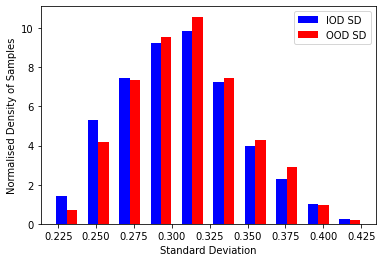

In [38]:
sd_test_IOD_df = pd.DataFrame(sd_test_IOD)
sd_test_OOD_df = pd.DataFrame(sd_test_OOD)
new_scores = np.concatenate([sd_test_IOD_df[col_no], sd_test_OOD_df[col_no]], axis=0)
minmaxscaler = MinMaxScaler()
new_scores_scaled = minmaxscaler.fit_transform(new_scores.reshape(-1, 1))

new_labels = np.concatenate([np.zeros_like(sd_test_IOD_df[col_no]), np.ones_like(sd_test_OOD_df[col_no])], axis=0)
histogram_df = pd.DataFrame(new_scores_scaled, new_labels)

#histogram_df.hist(column=0)

#sd_test_IOD_df.hist(column=0)
#sd_test_OOD_df.hist(column=0)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(sd_test_IOD_df[col_no].values.reshape(-1, 1), density=True)
b_heights, b_bins = np.histogram(sd_test_OOD_df[col_no].values.reshape(-1, 1), bins=a_bins, density=True)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width = width, facecolor='blue',label="IOD SD")
ax.bar(b_bins[:-1]+width, b_heights, width = width, facecolor='red', label="OOD SD")
ax.legend()
ax.set_xlabel("Standard Deviation")
ax.set_ylabel("Normalised Density of Samples")
fig.savefig("density_vs_sd_ensemble_neg_split_col_2.pdf")

0.5271980625868026


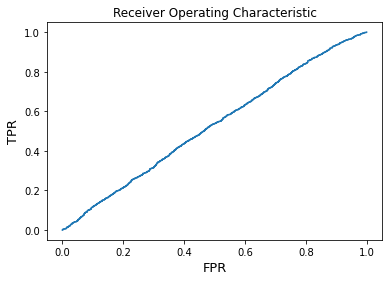

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score
norm_scores = new_scores - min(new_scores) / (max(new_scores) - min(new_scores))

auc = roc_auc_score(new_labels, new_scores)
fpr, tpr, threshs = roc_curve(new_labels, norm_scores, drop_intermediate=True)
print(auc)
plt.xlabel('FPR', fontsize=13)
plt.ylabel('TPR', fontsize=13)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr)
plt.savefig("auc_ensemble_neg_split_col_2.pdf")
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

mean_test, sd_test = ensemble_model.predict(x_test)
mean_test = q_scaler.inverse_transform(mean_test)
#sd_test_IOD = q_scaler.inverse_transform(sd_test_IOD)
q_unorm = q_scaler.inverse_transform(q_test)

mean_test_df = pd.DataFrame(mean_test)
sd_test_df = pd.DataFrame(sd_test)
q_df = pd.DataFrame(q_test)

MEAN = np.array(mean_test_df[0])
SD = np.array(sd_test_df[0])
Q = np.array(q_df[0])
Q = Q.reshape(-1, 1)


mean_scaler = MinMaxScaler()
MEAN = mean_scaler.fit_transform(MEAN.reshape(-1, 1))
sd_scaler = MinMaxScaler()
SD = sd_scaler.fit_transform(SD.reshape(-1, 1))

MSE = np.square(np.subtract(Q, MEAN))
plt.figure()

plt.scatter(SD, MSE)
plt.xlabel('Standard Deviation')
plt.ylabel('MSE')
#plt.savefig("./Art.pdf")
plt.show()